# UniverSeg + SAM
Some codes are from [UniverSeg](https://github.com/JJGO/UniverSeg/tree/main) and [Personalize-SAM](https://github.com/ZrrSkywalker/Personalize-SAM)

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
def plot_image(test_image,hard_pred_ori,mask_Fuse):
    # original image, UniverSeg, Ours
    plt.figure(figsize = (10,5))
    plt.subplot(1,3,1)
    plt.imshow(test_image.permute(0,2,3,1)[0])
    plt.title('Image')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(test_image.permute(0,2,3,1)[0])
    show_mask(hard_pred_ori[0,0,:], plt.gca())
    plt.title('Universeg\'s Prediction')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(test_image.permute(0,2,3,1)[0])
    show_mask(mask_Fuse, plt.gca())
    plt.title(' Our Prediction')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [2]:
import torch
from torch.nn import functional as F

import os
import cv2
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

from utils.UniSeg_SAM import *

In [3]:
# Set the checkpoint path first
# SAM_Checkpoint = '/userhome/jiesi/dataset/MedSAM/medsam_vit_b.pth'
SAM_Checkpoint = './checkpoints/medsam_vit_b.pth'

## Task 1

### Load data

In [4]:
ref_folder = './data/task1/support/image/' # Path of support set
inf_folder = './data/task1/query/image/' # Path of query set

In [5]:
# Support Set
ref_image_paths = sorted(os.listdir(ref_folder))
ref_image_paths = [os.path.join(ref_folder,i) for i in ref_image_paths if '.png' in i]
print('Total length of support set:',len(ref_image_paths))

support_mask_list, support_image_list = [], []
for test_image_path in ref_image_paths:
    test_mask_path = test_image_path.replace('/image/','/mask/')
    
    test_image = cv2.imread(test_image_path)
    test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
    test_mask = cv2.imread(test_mask_path)
    test_mask = cv2.cvtColor(test_mask, cv2.COLOR_BGR2RGB)
    
    test_mask = test_mask[:,:,0].astype('float')[None,None,:,:].clip(0,1)
    test_image = test_image.transpose(2,0,1)[None,:]
    
    support_mask_list.append(torch.tensor(test_mask))
    support_image_list.append(torch.tensor(test_image))

Total length of support set: 2


In [6]:
# Query set
inf_image_paths = sorted(os.listdir(inf_folder))
inf_image_paths = [os.path.join(inf_folder,i) for i in inf_image_paths if '.png' in i]
print('Total length of query set:',len(inf_image_paths))

Total length of query set: 3


### Load the model

In [7]:
# Load the model
Context_size = len(support_mask_list) 
alpha = 0.3*np.exp(-Context_size*0.1) 
beta = 2.0 
gamma = 0.5-0.5*np.exp(-Context_size*0.1) # Weight for UniverSeg in mask fusion module
print('Context_size:',Context_size,'alpha:',alpha,'beta:',beta,'gamma:',gamma)

predictor = UniSAM_predictor(alpha,
                            beta,
                            gamma,
                            Context_size,
                            checkpoint = SAM_Checkpoint)

Context_size: 2 alpha: 0.24561922592339452 beta: 2.0 gamma: 0.09063462346100909
sam.MedSAM_norm: True


In [8]:
predictor.set_support_images(
        support_image_list,
        support_mask_list,
        )

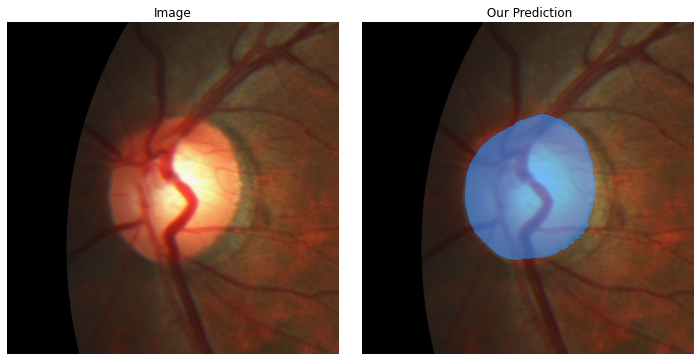

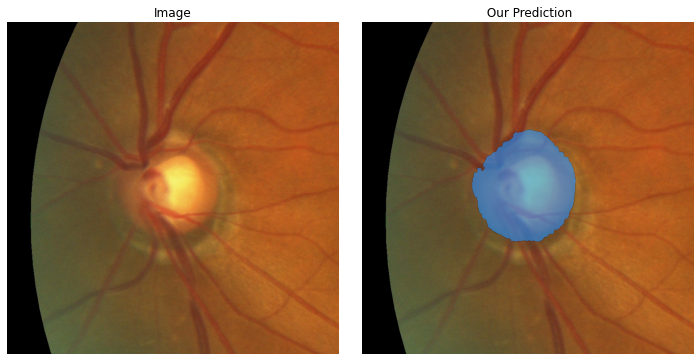

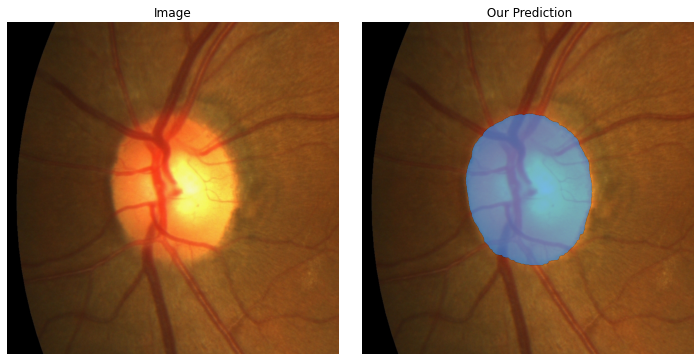

In [9]:
for i in inf_image_paths:
    test_image_path  = i
    test_image = cv2.imread(test_image_path)
    test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
    test_image = test_image.transpose(2,0,1)[None,:]
    test_image = torch.tensor(test_image)

    _, _, mask_Fuse = predictor.predict(test_image)
    
    plt.figure(figsize = (10,5))
    plt.subplot(1,2,1)
    plt.imshow(test_image.permute(0,2,3,1)[0])
    plt.title('Image')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(test_image.permute(0,2,3,1)[0])
    show_mask(mask_Fuse, plt.gca())
    plt.title(' Our Prediction')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

#### Comparison with original UniverSeg 

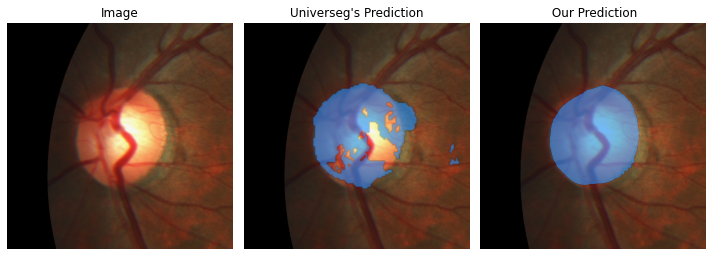

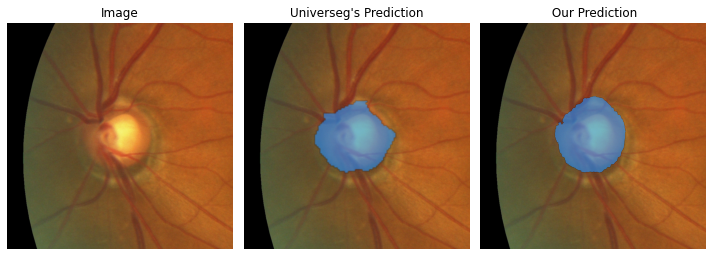

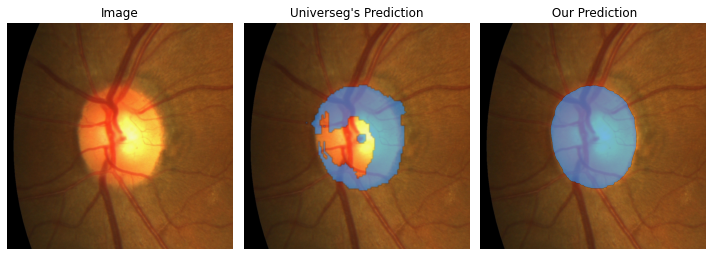

In [10]:
for i in inf_image_paths:
    test_image_path  = i
    test_image = cv2.imread(test_image_path)
    test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
    test_image = test_image.transpose(2,0,1)[None,:]
    test_image = torch.tensor(test_image)
    hard_pred_ori, _, _, mask_Fuse = predictor.predict_detailed(test_image)
    plot_image(test_image,hard_pred_ori,mask_Fuse)

## Task 2

### Load data

In [11]:
ref_folder = './data/task2/support/image/' # Path of support set
inf_folder = './data/task2/query/image/' # Path of query set

In [12]:
# Support Set
ref_image_paths = sorted(os.listdir(ref_folder))
ref_image_paths = [os.path.join(ref_folder,i) for i in ref_image_paths if '.png' in i]
print('Total length of support set:',len(ref_image_paths))

support_mask_list, support_image_list = [], []
for test_image_path in ref_image_paths:
    test_mask_path = test_image_path.replace('/image/','/mask/')
    
    test_image = cv2.imread(test_image_path)
    test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
    test_mask = cv2.imread(test_mask_path)
    test_mask = cv2.cvtColor(test_mask, cv2.COLOR_BGR2RGB)
    
    test_mask = test_mask[:,:,0].astype('float')[None,None,:,:].clip(0,1)
    test_image = test_image.transpose(2,0,1)[None,:]
    
    support_mask_list.append(torch.tensor(test_mask))
    support_image_list.append(torch.tensor(test_image))

Total length of support set: 4


In [13]:
# Query set
inf_image_paths = sorted(os.listdir(inf_folder))
inf_image_paths = [os.path.join(inf_folder,i) for i in inf_image_paths if '.png' in i]
print('Total length of query set:',len(inf_image_paths))

Total length of query set: 3


### Load the model

In [14]:
# Load the model
Context_size = len(support_mask_list)
alpha = 0.3*np.exp(-Context_size*0.1) 
beta = 2.0 
gamma = 0.5-0.5*np.exp(-Context_size*0.1) # Weight for UniverSeg in mask fusion module
print('Context_size:',Context_size,'alpha:',beta,'beta:',beta,'gamma:',gamma)

predictor = UniSAM_predictor(alpha,
                            beta,
                            gamma,
                            Context_size,
                            checkpoint = SAM_Checkpoint)

Context_size: 4 alpha: 2.0 beta: 2.0 gamma: 0.16483997698218034
sam.MedSAM_norm: True


In [15]:
predictor.set_support_images(
        support_image_list,
        support_mask_list,
        )

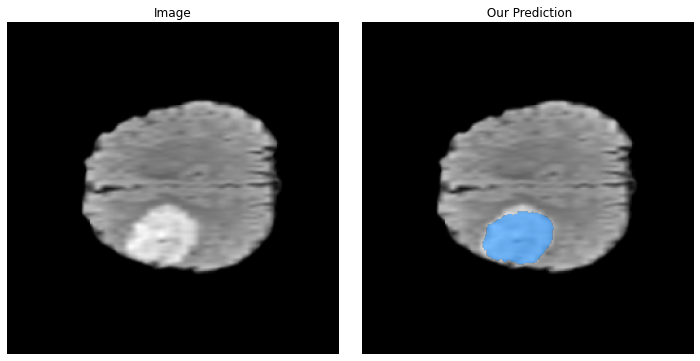

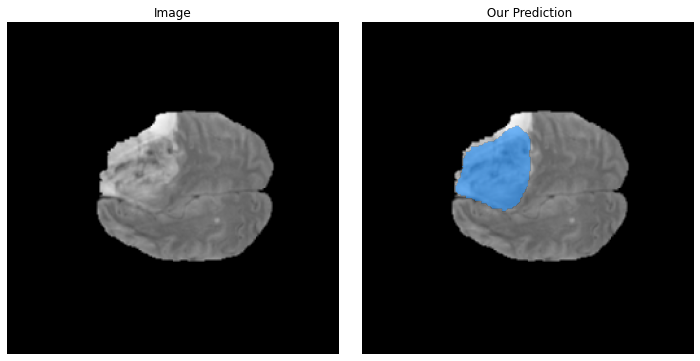

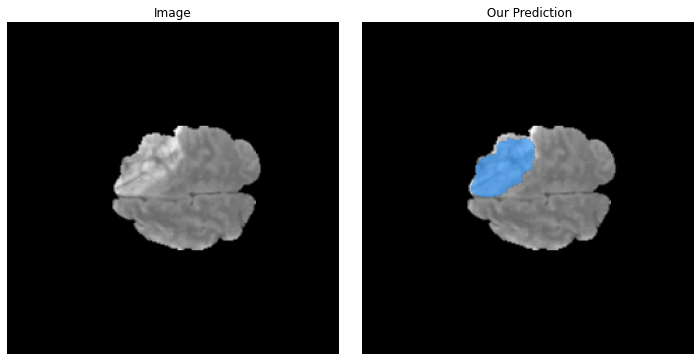

In [16]:
for i in inf_image_paths:
    test_image_path  = i
    test_image = cv2.imread(test_image_path)
    test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
    test_image = test_image.transpose(2,0,1)[None,:]
    test_image = torch.tensor(test_image)

    _, _, mask_Fuse = predictor.predict(test_image)
    
    plt.figure(figsize = (10,5))
    plt.subplot(1,2,1)
    plt.imshow(test_image.permute(0,2,3,1)[0])
    plt.title('Image')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(test_image.permute(0,2,3,1)[0])
    show_mask(mask_Fuse, plt.gca())
    plt.title(' Our Prediction')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

#### Comparison with original UniverSeg 

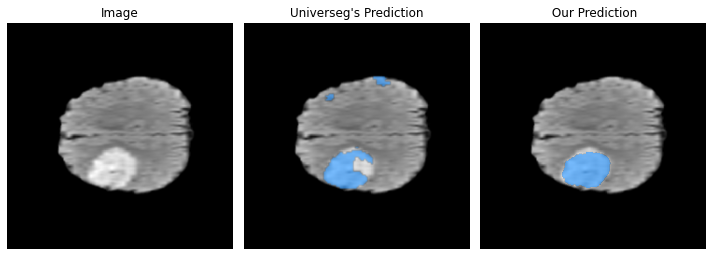

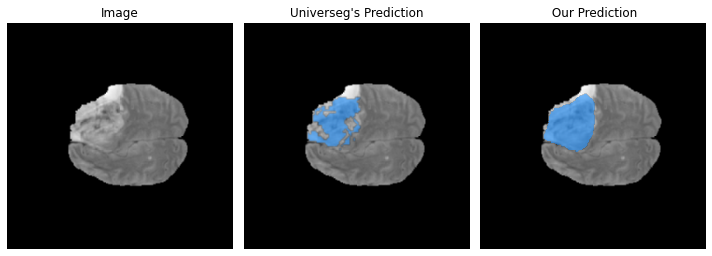

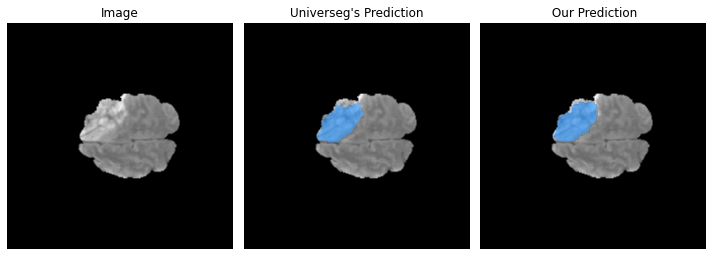

In [17]:
for i in inf_image_paths:
    test_image_path  = i
    test_image = cv2.imread(test_image_path)
    test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
    test_image = test_image.transpose(2,0,1)[None,:]
    test_image = torch.tensor(test_image)
    hard_pred_ori, _, _, mask_Fuse = predictor.predict_detailed(test_image)
    plot_image(test_image,hard_pred_ori,mask_Fuse)